<a href="https://colab.research.google.com/github/kengustafson/DD-DataScience/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Naive Bayes Classification to Predict Transaction Success**

**Deep Dive Data Science Project 1**

---
Ken Gustafson 2/19/2021

## Problem Definition

We desire to predict which customers will successfully make a specific transaction in the future, irrespective of the amount of money transacted.

Output to be produced: Customer's predicted transaction class, as either Successful or Unsuccessful.

Additional requirement: Predicting successful transactions and unsuccessful transactions are of equal importance.

## Supporting Functions

In [ ]:
def draw_histograms(df_zeros, df_ones, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(3.5*n_cols,3.5*n_rows))
    for idx, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,idx+1)
        data_zeros = df_zeros[var_name]
        data_ones  = df_ones[var_name]  
        bin_lims = 25     
        # Computing the histograms
        hist1, bins1 = np.histogram(data_zeros, bins=bin_lims)
        hist2, bins2 = np.histogram(data_ones, bins=bin_lims)
        # Normalizing
        hist1b = hist1/np.max(hist1)
        hist2b = hist2/np.max(hist2)
        # Plot the hostograms
        ax.plot(bins1[1:], hist1b, label = '0')
        ax.plot(bins2[1:], hist2b, label = '1')
        # Add the plot title
        ax.set_title(var_name+" Distribution")
        ax.legend()
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

## Data Collection

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection as model_selection
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
import sklearn.model_selection as model_selection

Additional criteria:

In [ ]:
# File Path Settings

file_name = '/content/drive/MyDrive/Data Science Student Material/Project 1 - Cohort 4/Data/Train.csv'

train = pd.read_csv(file_name)

In [ ]:
train.head()

,Unnamed: 0,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
train.shape

(180000, 203)

In [ ]:
train['target'].unique()

array([0, 1])

## Data Cleaning

In [ ]:
print(train.isna().sum())
print(train.isna().sum().sum())

Unnamed: 0    0
ID_code       0
target        0
var_0         0
var_1         0
             ..
var_195       0
var_196       0
var_197       0
var_198       0
var_199       0
Length: 203, dtype: int64
0


In [ ]:
train_clean = train.copy()

In [ ]:
train_clean.drop('ID_code', axis=1, inplace=True)

In [ ]:
train_clean.head()

,Unnamed: 0,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [ ]:
train_clean['Unnamed: 0'].unique()

array([     0,      1,      2, ..., 179997, 179998, 179999])

In [ ]:
train_clean.drop('Unnamed: 0', axis=1, inplace=True)

train_clean.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,10.8917,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,9.1738,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,19.3038,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


## Exploratory Data Analysis

In [ ]:
train_clean.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.00000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,...,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000,180000.000000
mean,0.100222,10.678650,-1.630045,10.712922,6.795317,11.080115,-5.072543,5.408688,16.550324,0.283391,7.566953,0.389307,-3.247011,14.024017,8.52808,7.537809,14.572828,9.333658,-5.701598,15.243424,12.439039,13.292016,17.264876,4.306171,3.020091,10.582012,13.667785,-4.046449,-1.138392,5.532218,5.053818,-7.681032,10.390373,-0.513852,14.777153,11.434945,3.842660,2.186827,5.867106,10.641125,...,24.250630,5.633311,5.362854,11.000203,-2.870288,19.320843,2.963064,-4.169666,4.936543,5.635896,-0.000418,-0.828670,19.833733,-0.668334,20.208845,11.639977,-2.796263,11.883072,-1.011819,2.595090,-2.740754,10.085543,0.723737,8.771600,12.756574,-3.987572,8.967249,-10.329649,15.379845,0.746816,3.236201,7.440715,1.927078,3.335039,17.995070,-0.143152,2.296054,8.909440,15.870166,-3.329476
std,0.300297,3.041036,4.050519,2.639146,2.043235,1.622641,7.856691,0.866265,3.417080,3.334465,1.235043,5.498553,5.974860,0.190038,4.64170,2.248606,0.412079,2.557970,6.713301,7.851050,8.001253,5.880714,8.203204,2.845792,0.526929,3.775518,0.285279,5.921909,1.523995,0.783689,2.617521,7.963103,2.160135,2.588038,4.324646,0.541385,5.182531,3.120066,2.249334,4.282035,...,10.882422,0.218022,1.419202,5.265133,5.455353,5.019303,0.369891,7.798037,3.109407,0.369629,4.422915,5.377361,8.675043,5.968300,7.132446,2.890315,7.520827,2.630682,8.580795,2.801692,5.258829,1.372147,8.960253,4.474509,9.320939,4.723643,3.189862,11.567947,3.944051,0.976402,4.561317,3.021636,1.476777,3.991292,3.135167,1.428452,5.455549,0.922101,3.010492,10.440819
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.277800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.01110,1.013300,13.076900,0.635100,-33.380200,-10.664200,-11.557600,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.551500,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000

Examine ratio of Unsuccessful (0) and Successful (1) transactions:

In [ ]:
sum(train_clean['target']==0) / (sum(train_clean['target']) + sum(train_clean['target']==0)) 

0.8997777777777778

In [ ]:
train_clean['target'].value_counts()

0    161960
1     18040
Name: target, dtype: int64

### Plots

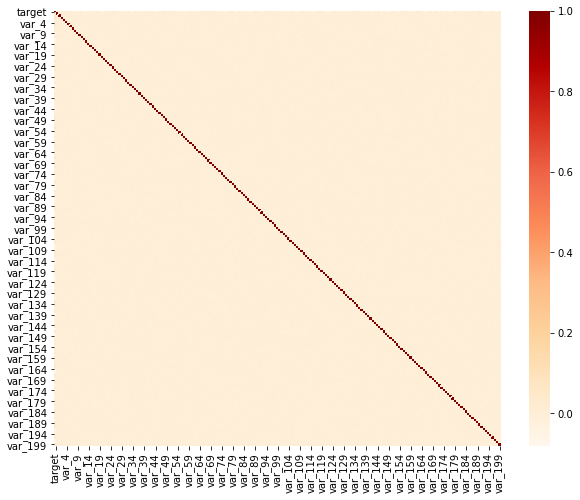

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(train_clean.corr(), cmap='OrRd', annot=False)

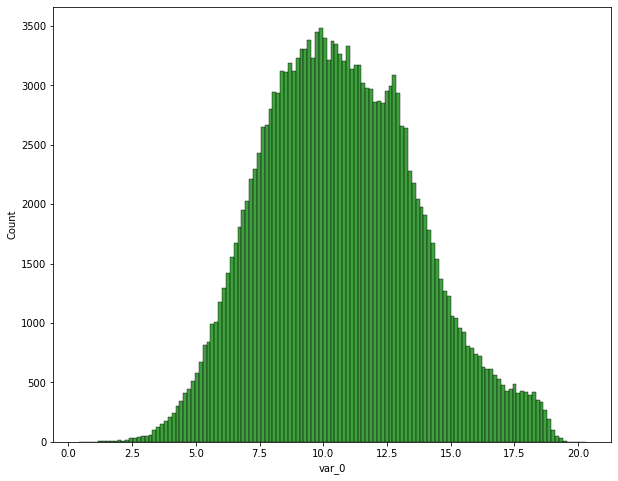

In [ ]:
plt.figure(figsize=(10,8))

sns.histplot(train_clean['var_0'], color='green');

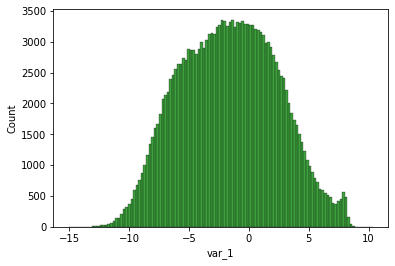

In [ ]:
sns.histplot(train_clean['var_1'], color='green');

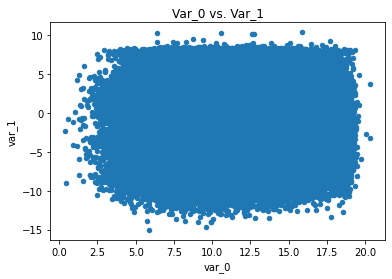

In [ ]:
train_clean.plot(kind='scatter', x='var_0', y='var_1', title='Var_0 vs. Var_1');

## Data Processing

### New dataframes

In [ ]:
success_df = train_clean[train_clean['target']==1].copy() success_df['target'].unique()

unsuccess_df = train_clean[train_clean['target']==0].copy() unsuccess_df['target'].unique()

target_df = train_clean['target'].copy()
target_df.describe()

var_df = train_clean.iloc[:, 1:201].copy()
var_df.shape

In [ ]:
var_corr = var_df.corr()

var_corr_mask = var_corr.abs() > .4

var_corr_mask.sum().sum()

#var_corr_filter[0:5, 'var_0']

#cols = var_df.corr().abs().nlargest(12, 'var_0')['var_0'].index
#cols

In [ ]:
model = GaussianNB()

X_train, X_test, y_train, y_test = model_selection.train_test_split(var_df, target_df, test_size=0.20)

print(X_train.shape)
print(X_test.shape)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))

print(metrics.confusion_matrix(y_test, y_pred))


(144000, 200)
(36000, 200)
0.9217222222222222
[[31894   520]
 [ 2298  1288]]


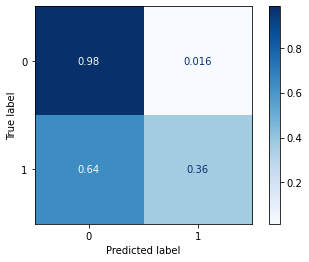

In [ ]:
metrics.plot_confusion_matrix(model, var_df, target_df, cmap=plt.cm.Blues, normalize='true')

In [ ]:
numLoops = 10
results  = np.zeros(numLoops)
resArray = np.zeros((2,2))

for idx in range(numLoops):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(var_df, target_df, test_size=0.20)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  results[idx] = metrics.accuracy_score(y_test, y_pred)
  resArray = resArray + metrics.confusion_matrix(y_test, y_pred)

print(results.mean())
print(resArray/numLoops)

0.9209722222222223
[[31855.89   530.36]
 [ 2314.64  1299.11]]


### Equalize the training set

In [85]:
var_equal_df = unsuccess_df.sample(frac = train_clean['target'].value_counts()[1] / train_clean['target'].value_counts()[0])

print(var_equal_df.shape)

train_equal = pd.concat([success_df, var_equal_df])

train_equal.reset_index(inplace=True, drop=True)

print(train_equal.shape)

train_equal.head()

train_equal.describe

(18040, 201)
(36080, 201)


<bound method NDFrame.describe of        target    var_0   var_1    var_2  ...  var_196  var_197  var_198  var_199
0           1  16.3699  1.5934  16.7395  ...   9.6846   9.0419  15.6064 -10.8529
1           1   5.3301 -2.6064  13.1913  ...   3.7600   9.4513  17.4105 -14.6897
2           1   7.7072  0.0183   9.9974  ...  -3.0468   7.5790  15.7685   5.4769
3           1  10.5358 -2.5439   8.7394  ...   5.3847   8.6949  15.1340   3.8449
4           1   6.7547  2.5973  14.2141  ...   6.8869   9.3567  18.9013  13.3447
...       ...      ...     ...      ...  ...      ...      ...      ...      ...
36075       0  13.5291 -2.5768   7.5699  ...  -4.9983   8.8179  15.3613 -12.2436
36076       0  12.0775  3.9713   8.8206  ...   7.1054  10.4548  18.7480  -0.6227
36077       0  11.1140  0.2312  13.5020  ...   9.0274   8.1605  15.8487  -7.7575
36078       0  10.6817  4.0571   8.7523  ...   0.5103   8.4845  19.2778 -18.2769
36079       0   6.4035 -5.2206  14.1464  ...   8.6821   8.6668  18.7276 -10

Retrain using non-biased data

Create training and target sets from the non-biased data

In [ ]:
target_equal = train_equal['target'].copy()
target_equal.describe()

var_equal = train_equal.iloc[:, 1:201].copy()
var_equal.shape

(36080, 200)

Retrain model using non-biased data, and check performance

In [82]:
numLoops = 100
results  = np.zeros(numLoops)
resArray = np.zeros((2,2))

for idx in range(numLoops):
  X_train, X_test, y_train, y_test = model_selection.train_test_split(var_equal, target_equal, test_size=0.20)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  results[idx] = metrics.accuracy_score(y_test, y_pred)
  resArray = resArray + metrics.confusion_matrix(y_test, y_pred)

print(results.mean())
print(results.std())
print(resArray/numLoops)

0.8041588137472284
0.0035396887709617042
[[2916.87  683.35]
 [ 729.84 2885.94]]


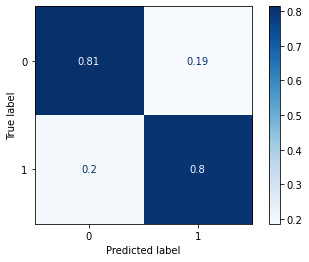

In [ ]:
metrics.plot_confusion_matrix(model, var_equal, target_equal, cmap=plt.cm.Blues, normalize='true')

## Data Visualizations

## Conclusions

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3607
           1       0.81      0.81      0.81      3609

    accuracy                           0.81      7216
   macro avg       0.81      0.81      0.81      7216
weighted avg       0.81      0.81      0.81      7216



## Stretch Goal

## Finish Project

Retrain model on all prior data

In [80]:
model.fit(var_equal, target_equal)

var_equal.shape

(36080, 200)

Clean new data (Test.csv)

In [69]:
test_file = "/content/drive/MyDrive/Data Science Student Material/Project 1 - Cohort 4/Data/Test.csv"

test_df = pd.read_csv(test_file)

print(test_df.shape)

test_df.head()

(20000, 201)


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,10.8917,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,9.1738,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,19.3038,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [90]:
#test_df.loc[:, 'var_0':'var_9']

new_pred = model.predict(test_df.loc[:, 'var_0':'var_199'])

#print(metrics.accuracy_score(y_test, y_pred))

#print(metrics.confusion_matrix(y_test, y_pred))

new_pred.shape

final_df = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Project 1 - Cohort 4/Data/sample_submission.csv')

final_df.head()

final_df['target'] = new_pred

final_df.head()

# Write new_pred to sample_submission.csv; overwrite target column

final_df.to_csv('/content/drive/MyDrive/Exercises - Ken/sample_submission.csv')